<a href="https://colab.research.google.com/github/valentintesta/Data-Science---Productos-Bancarios/blob/main/ML_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivos**

El objetivo del proyecto es, a través de los distintos logs (observaciones), que son transacciones sintéticas (simuladas) de dinero llevadas a cabo a través del móvil, detectar cuáles pueden ser fraudulentas.

Para poder realizar esto se deberá pasar por los distintos ciclos de la extracción de conocimiento (preparar los datos, minería de datos, visualización, etc), para conseguir la suficiente comprensión y estructura deseada de estos.

En resumen, los objetivos del proyecto son:

Estudiar el dataset y decidir cuáles son las técnicas a emplear
Aplicar técnicas de manipulación de datos necesarias (imputación, transformación, normalización, etc)
Visualización de datos con distintas gráficas
Detección de fraudes (Detectar correctactamente aquellos movimientos financieros fraudulentos)

# **Cargar Librerias**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest

from scipy.stats import chi2_contingency
from scipy.stats import chisquare

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss


np.random.seed(0)

# **Cargar Datos**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/fraude.csv')

# **Preprocesado de Datos**

## **Descripción de dataset**

In [ ]:
df.iloc[:10]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
df.shape

(6362620, 11)

Lo primero a tener en cuenta es la cantidad ingente de observaciones, las cuales se reducirán más adelante con undersampling.

Con dtypes se comprueba que la mayoría de variables son numéricas.

Por otro lado, entre las variables no numéricas se encuentra:

- type: clasifica tipo de transacción
- nameOrig y nameDest: especifica el usuario que realiza y el que recibe la transacción

In [ ]:
print("Estructura de los datos:")
print("***************")
print(df.columns)
print(df.dtypes)

Estructura de los datos:
***************
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


A continuación se procede a la visualización de información estadística del dataset



In [ ]:
print("Estadística: ")
print("***************")
df.describe()

Estadística: 
***************


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


La diferencia de rangos en los valores numéricos denota la necesidad de emplear la normalización, esto se realiza más adelante en el notebook

## **Valores Ausentes**

Se comprueba si existe algún valor ausente en el dataset con isnull().values.any()



In [ ]:
df.isnull().values.any()


False

No existen observaciones con valores perdidos



## **Distribución de variables**

### **Type**

Interesa, para el caso de estudio, descubrir cuándo es más frecuente que ocurran los fraudes. Por ello, se estudia la distribución de la variable type.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0.5, 1.0, 'Distribución del tipo de transacción')

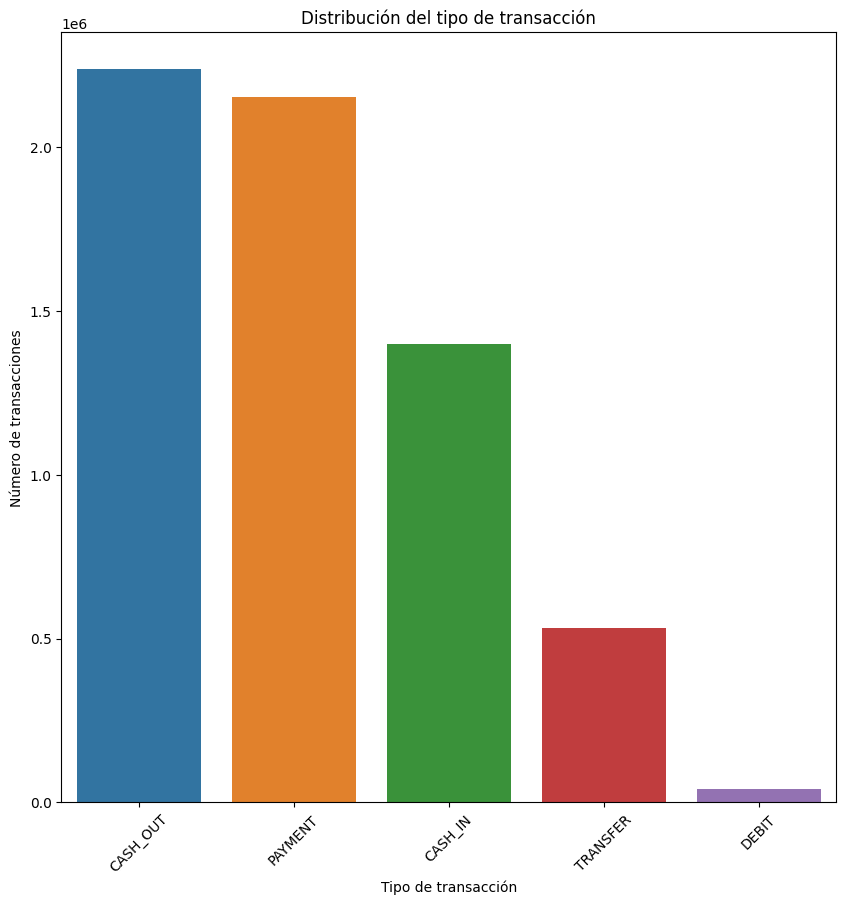

In [ ]:
print(df['type'].value_counts())

plt.rcParams['figure.figsize']=[10,10]
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Distribución del tipo de transacción')

Las transacciones más comunes son PAYMENT Y CASH_OUT





### **isFraud (target)**

In [ ]:
df_isFraud = df[(df['isFraud'] == 1)]
df_isFraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


Se observa que de los más de 6.3 millones de observaciones, 8213 son fraudulentas



In [ ]:
print(df['isFraud'].value_counts())

0    6354407
1       8213
Name: isFraud, dtype: int64


Las clases se encuentran enormemente desbalanceadas, como se aprecia, tan solo el 0.13% de las observaciones se clasifican como fraude.

In [ ]:
total = df['isFraud'].value_counts()[0] + df['isFraud'].value_counts()[1]
fraud = (df['isFraud'].value_counts()[1]/total) * 100
print('Porcentaje de operaciones fraudulentas:', fraud)

Porcentaje de operaciones fraudulentas: 0.12908204481801522


#### Grafica de Barras

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


Text(0.5, 1.0, 'Tipo de transacción cuando hay fraude')

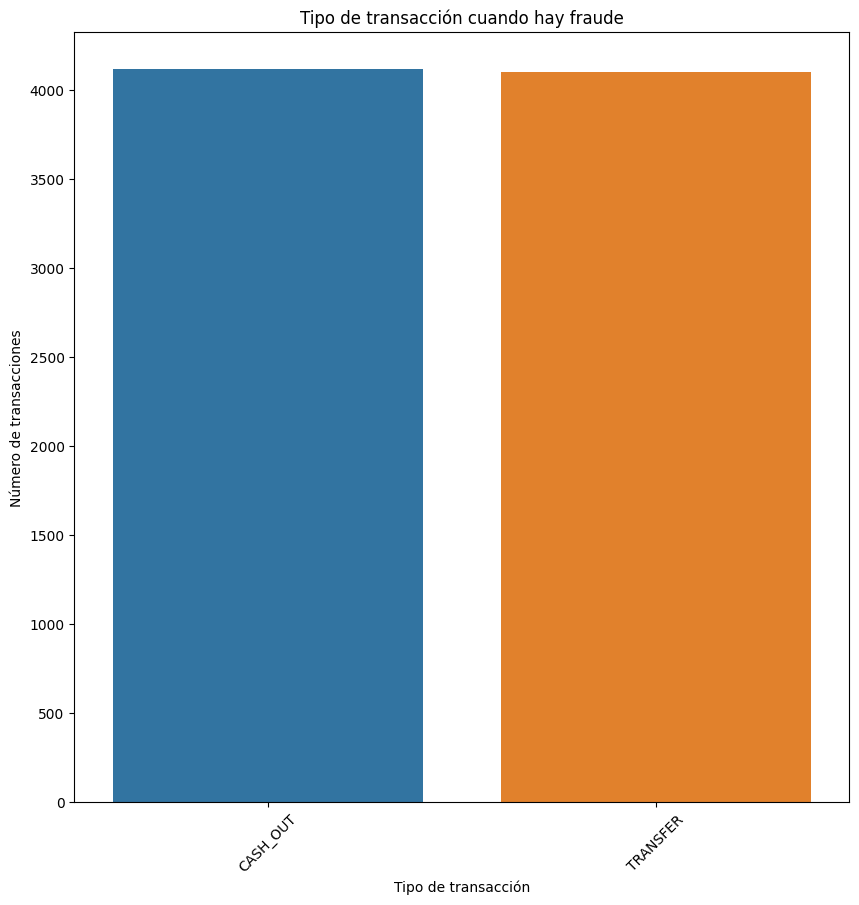

In [ ]:
print(df[(df['isFraud'] == 1)]['type'].value_counts())

plt.figure(figsize=(10,10))
sns.countplot(x='type', data=df[(df['isFraud'] == 1)], order=df[(df['isFraud'] == 1)]['type'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Tipo de transacción cuando hay fraude')

Este gráfico revela información muy valiosa, las transacciones fraudulentas sólo ocurren cuando es de tipo TRANSFER (transferencia) y CASH_OUT (sacar dinero)

In [ ]:
df[(df['isFraud'] == 1)]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


### **Amount**

En la siguiente gráfica se puede ver la distribución de la variable isFraud con amount.



<Axes: xlabel='isFraud', ylabel='amount'>

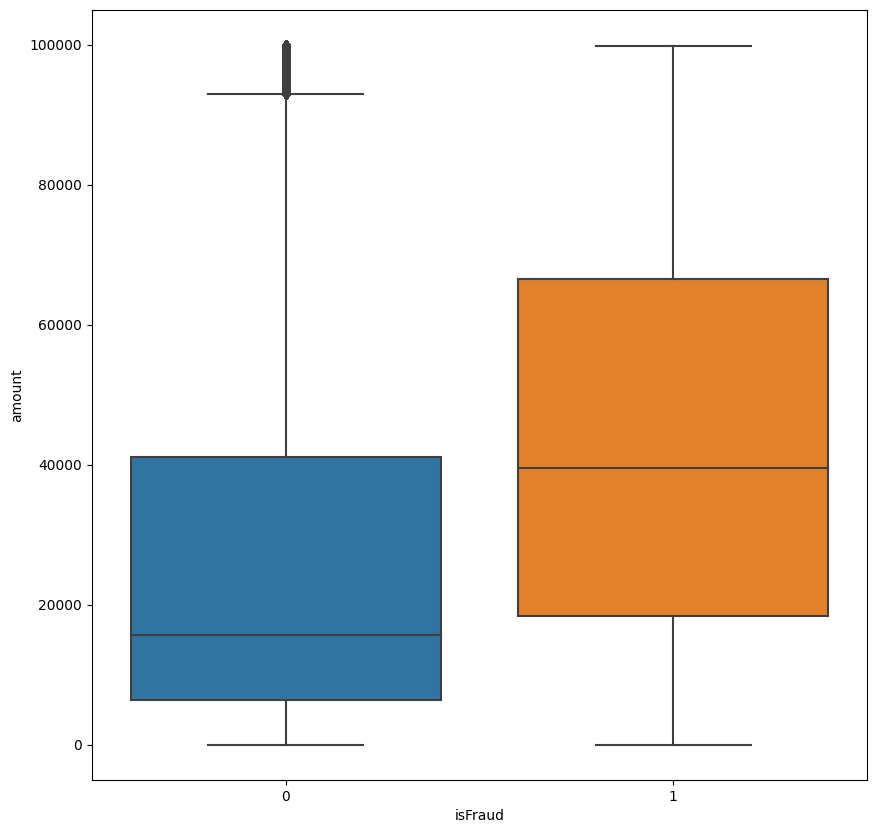

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

Se aprecia que el fraude ocurre más frecuentemente cuando la variable amount es mayor



### **isFlaggedFraud**

- Se detecta un patrón interesante. De los 16 registros existentes en el dataset, TODOS tienen las variables oldbalanceDest y newbalanceDest a 0.

- Además, la variable oldbalanceOrg y newbalanceOrg tienen también exactamente el mismo valor, no se descuenta la cantidad de dinero de la transacción

- También se aprecia que sólo las de type TRANSFER tienen la variable isFlaggedFraud a 1, es decir, sólo cuando hay una transacción superior a 200k, el sistema marca, de forma preventiva, esa transacción como fraudulenta

In [ ]:
df[(df['isFlaggedFraud'] == 1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


#### **newbalanceDest y oldbalanceDest**
Se comprueba que el 65% de las observaciones que son fraude tienen los valores 0 en alguna de estas variables

In [ ]:
total = df[(df['isFraud'] == 1)]['type'].count()
print('Existen ', total, ' observaciones que son fraude')

Existen  8213  observaciones que son fraude


In [ ]:
both = df_isFraud[(df_isFraud['newbalanceDest'] == 0) | (df_isFraud['oldbalanceDest'] == 0)].count()['oldbalanceDest']
print('Veces que aparecen ambas variables, newbalanceDest = oldbalanceDest = 0, cuando la observación es fraude: ', both)


Veces que aparecen ambas variables, newbalanceDest = oldbalanceDest = 0, cuando la observación es fraude:  5366


In [ ]:
porcentaje = (both/total) * 100
print('Porcentaje de observaciones con 0 en las variables cuando hay fraude: ', porcentaje)

Porcentaje de observaciones con 0 en las variables cuando hay fraude:  65.33544380859612


Ahora se va a observar para el dataset sin fraude que esto sólo ocurreun 44% de las veces



In [ ]:
total2 = df[(df['isFraud'] == 0)]['type'].count()
print('Existen ', total2, ' observaciones que NO son fraude')

Existen  6354407  observaciones que NO son fraude


In [ ]:
both2 = df[(df['newbalanceDest'] == 0) | (df['oldbalanceDest'] == 0)].count()['oldbalanceDest']
print('Veces que aparecen ambas variables, newbalanceDest = oldbalanceDest = 0, cuando la observación NO es fraude: ', both2)

Veces que aparecen ambas variables, newbalanceDest = oldbalanceDest = 0, cuando la observación NO es fraude:  2826539


In [ ]:
porcentaje2 = (both2/total2) * 100
print('Porcentaje de observaciones con 0 en las variables cuando NO hay fraude: ', porcentaje2)

Porcentaje de observaciones con 0 en las variables cuando NO hay fraude:  44.4815542976709


El porcentaje de las variables newbalanceDest o oldbalanceDest = 0 es mayor cuando hay fraude

####**newbalanceOrig y oldbalanceOrg**

- Para estas variables, se va a comprobar la cantidad de veces que ambas son iguales, es decir, que ocurre newbalanceOrig = oldbalanceOrg

- Para las observaciones fraudulentas:

In [ ]:
orig_both = df_isFraud[(df_isFraud['newbalanceOrig'] == df_isFraud['oldbalanceOrg'])].count()['oldbalanceOrg']
print('Veces que aparecen ambas variables, newbalanceOrig = oldbalanceOrg, cuando la observación es fraude: ', orig_both)

Veces que aparecen ambas variables, newbalanceOrig = oldbalanceOrg, cuando la observación es fraude:  57


In [ ]:
porcentaje3 = (orig_both/total) * 100
print('Porcentaje de observaciones con el mismo valor en las variables: ', porcentaje3)

Porcentaje de observaciones con el mismo valor en las variables:  0.6940216729575064


- Con el dataset sin fraude



In [ ]:
orig_both2 = df[(df['newbalanceOrig'] == df['oldbalanceOrg'])].count()['oldbalanceOrg']
print('Veces que aparecen ambas variables, newbalanceOrig = oldbalanceOrg, cuando la observación NO es fraude: ', orig_both2)

Veces que aparecen ambas variables, newbalanceOrig = oldbalanceOrg, cuando la observación NO es fraude:  2089037


In [ ]:
porcentaje4 = (orig_both2/total2) * 100
print('Porcentaje de observaciones con el mismo valor en las variables: ', porcentaje4)

Porcentaje de observaciones con el mismo valor en las variables:  32.87540442404775


Es interesante observar que el porcentaje de veces que ambas son iguales es mucho superior en el dataset sin fraude

### **step**

La variable step es el momento de la simulación (30 días), en la que se realiza la transacción

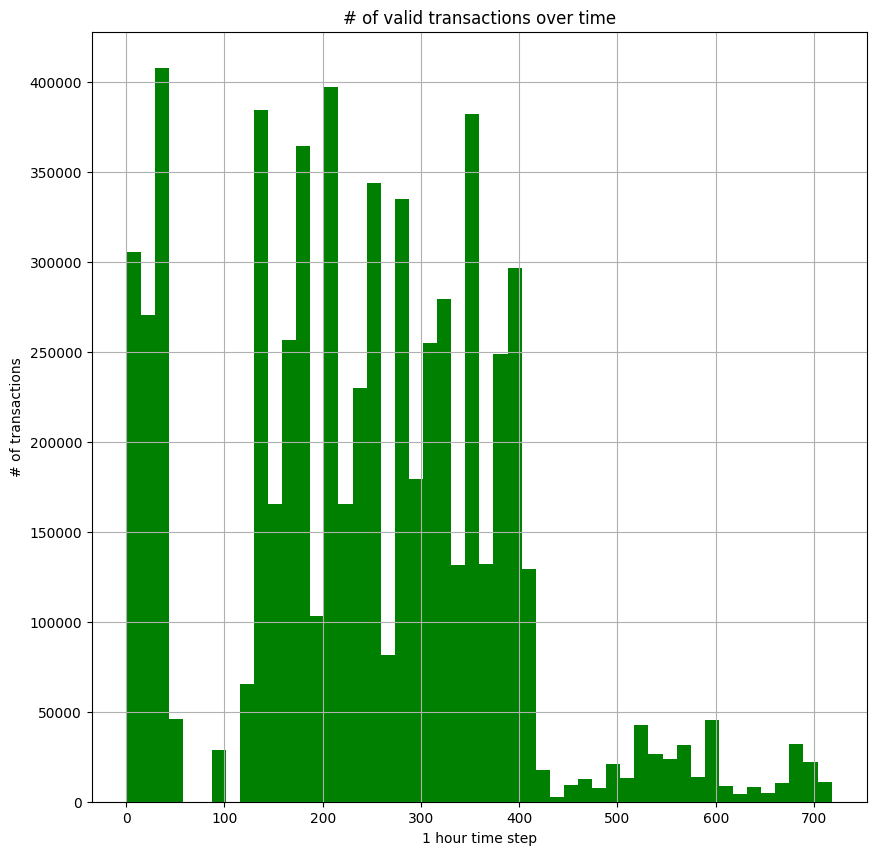

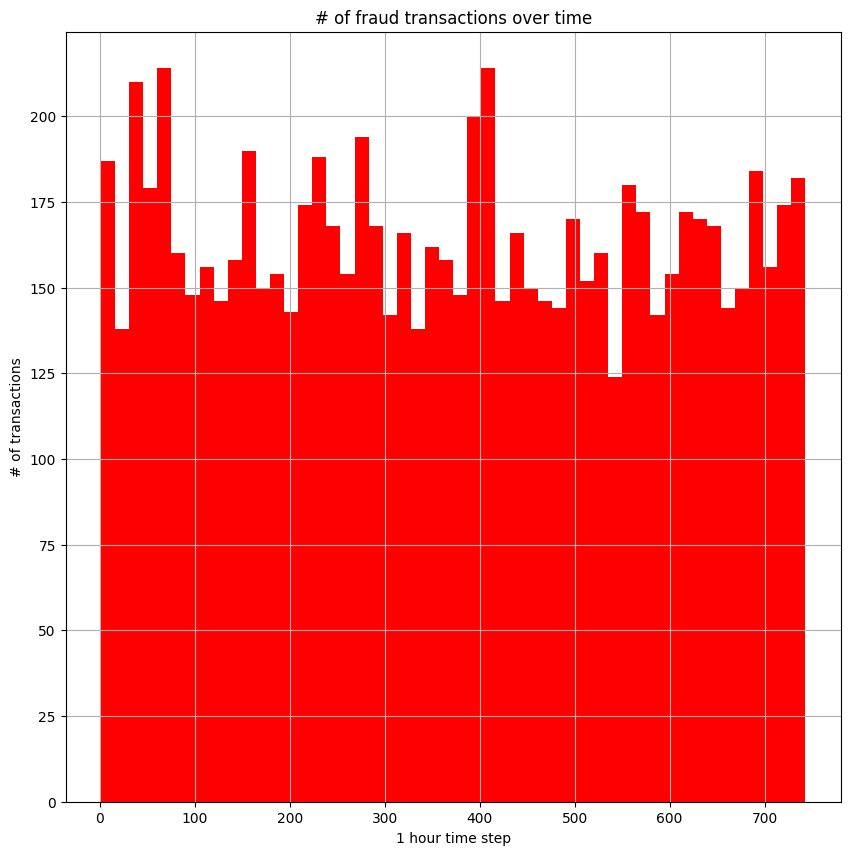

<Figure size 1000x1000 with 0 Axes>

In [ ]:
bins = 50

df[(df['isFraud'] == 0)].hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

df[(df['isFraud'] == 1)].hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.figure(figsize=(10,10))
plt.show()

Se observa que después de step 400 las transacciones reales disminuyen considerablemente, mientras que las fraudulentas se mantienen constantes.

Esto puede hacernos pensar que a partir de step 400 hay más proporción de operaciones fraudulentas que antes.

## **Manejando variables categóricas**
Muchos modelos necesitan procesar únicamente variables numéricas, por esto es necesario pasar variables categóricas a numéricas. Una de las técnicas es crear variables dummy, donde se crea una nueva variable por cada valor de la variable vategórica que se quiere transformar.

In [ ]:
# Se crean variables dummy y se eliminan las categóricas
# Nótese que se eliminan tambien la cuenta de destino y origen ya que
# no se consideran variables importantes
dataset = pd.concat([df.drop(columns=['isFraud','isFlaggedFraud']),pd.get_dummies(df.type)] ,axis=1)
dataset = dataset.drop(['type', 'nameOrig', 'nameDest'],1)
dataset = pd.concat([dataset,df.iloc[:,-2:]],axis=1)
pd.DataFrame.head(dataset)

<ipython-input-28-158e0166a7c7>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop(['type', 'nameOrig', 'nameDest'],1)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0,0


## **Análisis de Redundancia**

###**De atributos**
Se va a comprobar la redundancia de atributos mediante el análisis de la correlación en el dataset, ya que todas las variables son numéricas.

- Correlación de Pearson (variables cuantitativas)

- Creo la matrix de correlación con la función corr()

In [ ]:
cuantitativas = dataset.iloc[:,:6]

In [ ]:
cuantitativas.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [ ]:
corr_mat = cuantitativas.corr(method="pearson")
corr_mat.style.background_gradient(cmap='coolwarm')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000


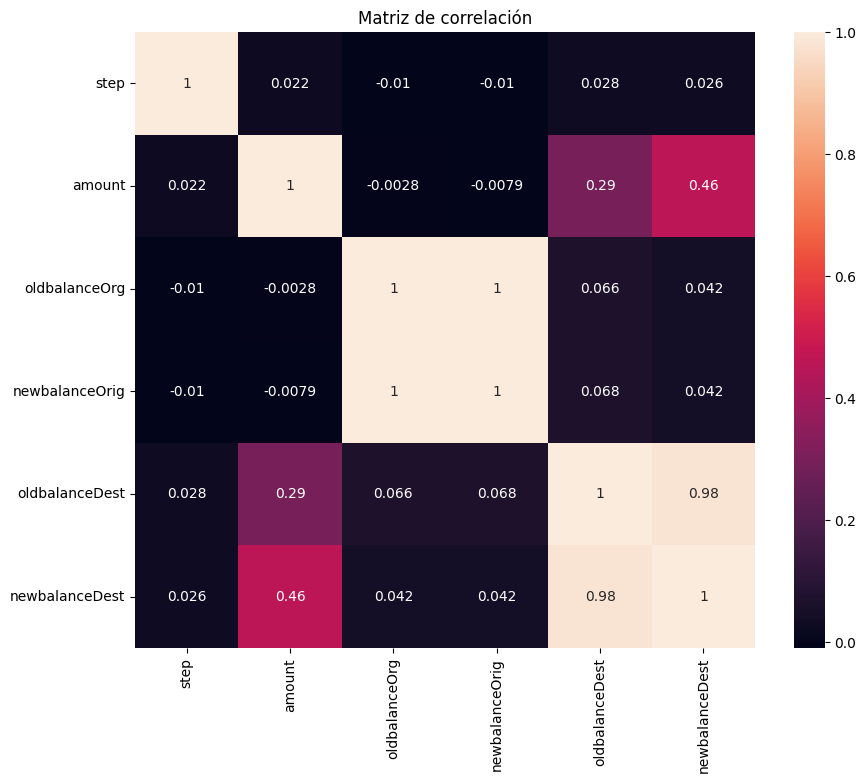

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True)
plt.title("Matriz de correlación")
plt.show()

Se puede observar una enorme correlacion enre las siguientes variables:

- oldbalanceDest y newbalanceDest
- oldbalanceOrg y newbalanceOrig

Esta correlación es debida a la clara influencia que existen entre las variables. Por ejemplo, cuando se envia dinero a un destinatario, ese alguien aumenta su capital, mientras que el origen disminuye.

De momento no se elimina ninguna porque no se detectan fuertes correlaciones entre la mayoría de variables.

Además, se van a ver otros métodos más adelante como el PCA, que escoge las variables a eliminar, para la reducción de dimensionalidad del dataset.

### **De registros**

Mediante el test de Chi cuadrado se compreuba la correlación de algunos atributos cualitativos


Los atributos que toman valores 0 y 1 se cuentan como atributos cualitativos, y deben ser analizados aquí y no en la matriz de correlación

In [ ]:
chi_df = df.isFraud.replace(to_replace=[0,1], value=['no','yes'])
chi_df = pd.concat([df.drop('isFraud',1),chi_df] ,axis=1)
chi_df.head()

<ipython-input-33-0c48c8d8410d>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chi_df = pd.concat([df.drop('isFraud',1),chi_df] ,axis=1)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,no
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,no
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,yes
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,yes
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,no


In [ ]:
# creación de la tabla de contingencia con las dos columnas que se quieren estudiar
observados = pd.crosstab(chi_df['isFraud'], chi_df.type, margins=True)

In [ ]:
observados

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
isFraud,,,,,,
no,1399284,2233384,41432,2151495,528812,6354407
yes,0,4116,0,0,4097,8213
All,1399284,2237500,41432,2151495,532909,6362620


In [ ]:
test = chi2_contingency(observados)
test

Chi2ContingencyResult(statistic=22082.53571319108, pvalue=0.0, dof=10, expected_freq=array([[1.39747778e+06, 2.23461179e+06, 4.13785187e+04, 2.14871781e+06,
        5.32221110e+05, 6.35440700e+06],
       [1.80622440e+03, 2.88821075e+03, 5.34812728e+01, 2.77719374e+03,
        6.87889834e+02, 8.21300000e+03],
       [1.39928400e+06, 2.23750000e+06, 4.14320000e+04, 2.15149500e+06,
        5.32909000e+05, 6.36262000e+06]]))

En la salida se obserban varios valores:

- Estadistico (suma de las diferencias al cuadrado
- P-valor
- Tabla de valores esperados

El segundo valor que sale en la salida lleva a pensar que estas variales son muy correladas

In [ ]:
# convierto la tabla en dataframe
esperados = pd.DataFrame(test[3])
esperados

,0,1,2,3,4,5
0,1.397478e+06,2.234612e+06,41378.518727,2.148718e+06,532221.110166,6354407.0
1,1.806224e+03,2.888211e+03,53.481273,2.777194e+03,687.889834,8213.0
2,1.399284e+06,2.237500e+06,41432.000000,2.151495e+06,532909.000000,6362620.0


In [ ]:
esperados_rel = esperados.apply(lambda r: r/len(chi_df) *100,axis=1)


In [ ]:
observados_rel = observados.apply(lambda r: r/len(chi_df) *100,axis=1)


In [ ]:
observados_rel

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
isFraud,,,,,,
no,21.992261,35.101641,0.651178,33.814608,8.311230,99.870918
yes,0.000000,0.064690,0.000000,0.000000,0.064392,0.129082
All,21.992261,35.166331,0.651178,33.814608,8.375622,100.000000


In [ ]:
esperados_rel

,0,1,2,3,4,5
0,21.963873,35.120937,0.650338,33.770959,8.364811,99.870918
1,0.028388,0.045393,0.000841,0.043649,0.010811,0.129082
2,21.992261,35.166331,0.651178,33.814608,8.375622,100.000000


In [ ]:
test[1]

0.0

- Como el p valor < 0.05 podemos afirmar que las variables están correlacionadas

- Nunca ocurrira que una operación CASH_IN sea fraude

### **Duplicados**
Se comprueba que no existen registros duplicados

El método de python duplicated(), selecciona los registros coincidentes, excepto la primera ocurrencia de cada coincidencia, basandose en todas las columnas

In [ ]:
df.duplicated().any()

False

Duplicados basandose en todos los atributos



In [ ]:
df_duplicate = df[df.duplicated()]
if (df_duplicate.size < 1):
  print("No existen columnas duplicadas basándose en todos los atributos: ")
print(df_duplicate)

No existen columnas duplicadas basándose en todos los atributos: 
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


Duplicados basandose en atributos seleccionados



In [ ]:
df_duplicate = df[df.duplicated(['nameOrig', 'type','newbalanceOrig'])]
print("Registros duplicados según atributos especificos: ")
print(df_duplicate)

Registros duplicados según atributos especificos: 
         step      type      amount     nameOrig  oldbalanceOrg  \
294115     15  TRANSFER  1933468.14   C813633808            0.0   
379235     17  CASH_OUT    21789.38  C1823562588            0.0   
462165     19  CASH_OUT   127391.74   C494623691            0.0   
530415     20  CASH_OUT   154903.22   C443788923        30049.0   
544035     21   PAYMENT    15065.21  C1389563190            0.0   
...       ...       ...         ...          ...            ...   
6342978   692  CASH_OUT    60207.45  C1162474222        31294.0   
6351323   705  CASH_OUT    36126.00   C534198506          817.0   
6353901   707  CASH_OUT   319760.77  C1450140233       117538.0   
6357276   710  CASH_OUT   186509.82  C1101600194       158484.0   
6360204   715  TRANSFER   118688.81  C1313642079       110425.0   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
294115              0.0  C1648633036      5467502.75      74009

##**Balanceo de Clases**
Al contar con esta ingente cantidad de observaciones, se aprecia un desbalenceo importante en las clases de la variable objetivo. El porcentaje de observaciones clasificadas como fraudes es de apenas un 0.13%

In [ ]:
total = dataset['isFraud'].value_counts()[0] + df['isFraud'].value_counts()[1]
fraud = (df['isFraud'].value_counts()[1]/total) * 100
print('Porcentaje de operaciones fraudulentas:', fraud)

Porcentaje de operaciones fraudulentas: 0.12908204481801522


Para intentar solventar este problema, se procede al undersampling o submuestreo. Esto lo que hará es disminuir el número de observaciones pertenecientes a la clase mayoritaria (en este caso son las operaciones no fraudulentas), hasta igualar al número de observaciones de la clase minoritaria (observasciones fraudulentas)


###**Submuestreo aleatorio con imbalanced-learn:**

Busca agrupar los registros de la clase mayoritaria y hacer un submuestreo eliminando registros de cada grupo, buscando así preservar la información.

In [ ]:
columns = dataset.columns
X = dataset.drop('isFraud',1)
y = dataset.isFraud

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)
print(pd.Series(y_under).value_counts())

<ipython-input-47-720ecc374d54>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = dataset.drop('isFraud',1)


0    8213
1    8213
Name: isFraud, dtype: int64


In [ ]:
 columns_X = np.delete(columns, 11)
 columns_y = columns[-2]

In [ ]:
X_df = pd.DataFrame(X_under, columns=columns_X)
y_df = pd.DataFrame(y_under, columns=[columns_y])

new_df = pd.concat([X_df, y_df], axis=1)
new_df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
0,139,265803.35,0.00,0.00,751669.39,1017472.74,0,1,0,0,0,0,0
1,589,11278.28,0.00,0.00,220970.84,232249.12,0,1,0,0,0,0,0
2,284,16363.06,35966.16,19603.10,0.00,0.00,0,0,0,1,0,0,0
3,37,107223.31,20752629.71,20859853.02,804594.62,571711.22,1,0,0,0,0,0,0
4,287,3678.25,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16421,743,339682.13,339682.13,0.00,0.00,339682.13,0,1,0,0,0,0,1
16422,743,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,1,0,1
16423,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,1,0,0,0,0,1
16424,743,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,1,0,1


El undersampling ha sido realizado con éxito.



<Axes: title={'center': 'Distribución después de submuestreo'}>

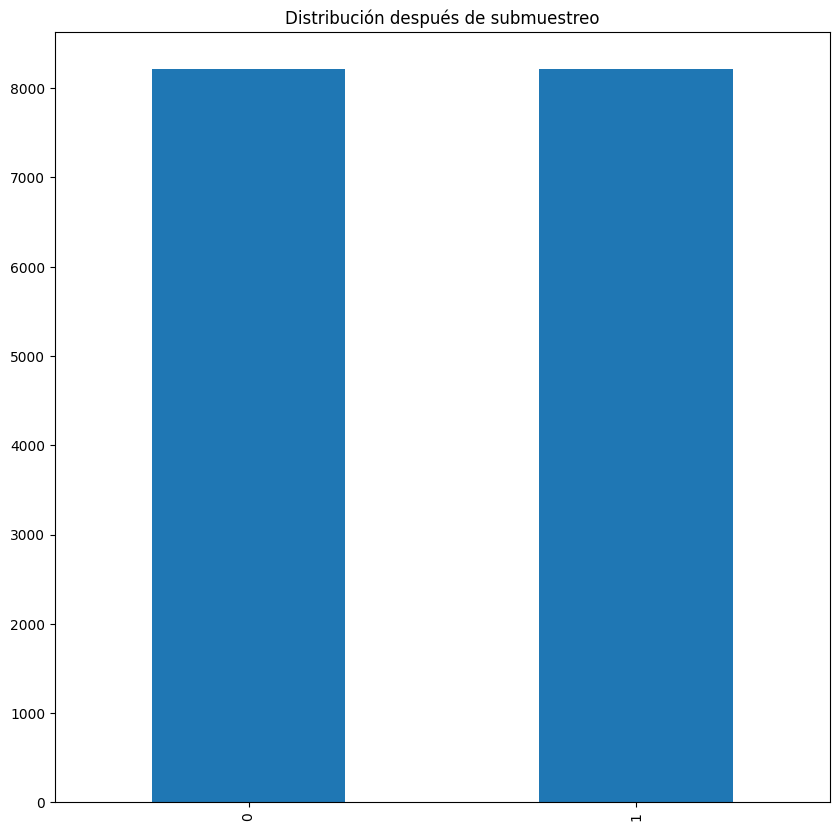

In [ ]:
plt.rcParams['figure.figsize']=[10,10]
new_df.isFraud.value_counts().plot(kind='bar', title='Distribución después de submuestreo')

In [ ]:
total = new_df['isFraud'].value_counts()[0] + df['isFraud'].value_counts()[1]
fraud = (new_df['isFraud'].value_counts()[1]/total) * 100
print('Porcentaje de operaciones fraudulentas:', fraud)

Porcentaje de operaciones fraudulentas: 50.0


De esta forma se han conseguido dos importantes tareas:

- Reducir la dimensionalidad del dataset
- Balancear las clase



##**Deteccion de anamalias**

Para saber si se ha perdido o no información, es necesario realizar la tarea de detección de anomalías con y sin balanceo.

Se va a realizar con 3 clasificadores:

- Árbol de decisión

- Regresión Logística

- Random Forest

### **Sin balanceo (Árbol de decisión)**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( dataset.drop(columns=["isFraud"]), dataset.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
predictions = DT.predict(test_X)

In [ ]:
# Evaluate predictions
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT.predict(test_X)))

0.9997216556319077
[[907655    122]
 [   131   1038]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.89      0.89      0.89      1169

    accuracy                           1.00    908946
   macro avg       0.95      0.94      0.95    908946
weighted avg       1.00      1.00      1.00    908946



Se observa un buen rendimiento en general, pero detecta mejor una clase que otra



### **Sin balanceo (Regresión Logística)**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( dataset.drop(columns=["isFraud"]), dataset.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# predice la clase de test
predictions = LR.predict(test_X)

In [ ]:
# Evaluate predictions
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.9982265173068587
[[906850    927]
 [   685    484]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.34      0.41      0.38      1169

    accuracy                           1.00    908946
   macro avg       0.67      0.71      0.69    908946
weighted avg       1.00      1.00      1.00    908946



Se aprecia que, aunque el accuracy del modelo es del 99.8%, este no es tan bueno como parece.

Si nos fijamos en la matriz de confusión, este modelo clasifica perfectamente las operaciones reales, pero las que son fraudulentas sólo es capaz de clasificarlas correctamente un 34% de las veces

###**Sin balanceo (Random Forest)**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( dataset.drop(columns=["isFraud"]), dataset.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
RF = RandomForestClassifier()
# se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# predice la clase de test
predictions = RF.predict(test_X)

# Evalúa el modelo y muestra los resultados
accuracy = RF.score(test_X, test_y)
classification_rep = classification_report(test_y, predictions)
print(f"Accuracy: {accuracy:.2f}")
print(classification_rep)

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.98      0.79      0.87      1169

    accuracy                           1.00    908946
   macro avg       0.99      0.89      0.94    908946
weighted avg       1.00      1.00      1.00    908946



### **Con balanceo (Árbol de decisión)**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( new_df.drop(columns=["isFraud"]), new_df.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
predictions = DT.predict(test_X)

In [ ]:
# Evaluate predictions
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT.predict(test_X)))

0.9889220281210055
[[1165    9]
 [  17 1156]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1174
           1       0.99      0.99      0.99      1173

    accuracy                           0.99      2347
   macro avg       0.99      0.99      0.99      2347
weighted avg       0.99      0.99      0.99      2347



Ha mejorado la predicción de las observaciones que son fraude, y disminuido muy legeramente las que no lo son. En general, ahora es un mejor modelo que sin balanceo

### **Con balanceo (Regresión Logística)**

Aunque el accuracy o precisión de clasificación de este modelo es menor frente al modelo sin balanceo, se aprecia que este es mucho más válido para la tarea que nos atañe, la detección de operaciones fraudulentas.

En esta ocasión, el modelo que trabaja con los datos balanceados, ha clasificado aquellas operaciones fraudulentas con una tasa de éxito del 92%, contra el 34% que conseguía el otro.

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( new_df.drop(columns=["isFraud"]), new_df.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# predice la clase de test
predictions = LR.predict(test_X)

In [ ]:
# Evaluate predictions
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.9041329356625479
[[1070  104]
 [ 121 1052]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1174
           1       0.91      0.90      0.90      1173

    accuracy                           0.90      2347
   macro avg       0.90      0.90      0.90      2347
weighted avg       0.90      0.90      0.90      2347



### **Con balanceo (Random Forest)**

Definitivamente el Random Forest con el dataset balanceado es el modelo más acertado en este caso, pues clasifica ambas clases con una tasa de acierto del 99%.

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( new_df.drop(columns=["isFraud"]), new_df.isFraud, test_size=1/7.0, random_state=0)

RF = RandomForestClassifier()

# se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# predice la clase de test
predictions = RF.predict(test_X)

# Evaluate predictions
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.9927567106945037
[[1164   10]
 [   7 1166]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1174
           1       0.99      0.99      0.99      1173

    accuracy                           0.99      2347
   macro avg       0.99      0.99      0.99      2347
weighted avg       0.99      0.99      0.99      2347



## **Normalizado y escalado**
Como se vio en el apartado de descripción del dataset, con la funcion describe(), existe una gran diferencia en la eslaca de los atributos numéricos.

A continuación, se muestra con la siguiente gráfica la distribución de las variables y cómo normalizar los datos.

Se debe tener en cuenta, que solo se van a normalizar las primeras 6 variables, que son las consideradas númericas, el resto son categóricas, dado que representan factores

<Axes: ylabel='Density'>

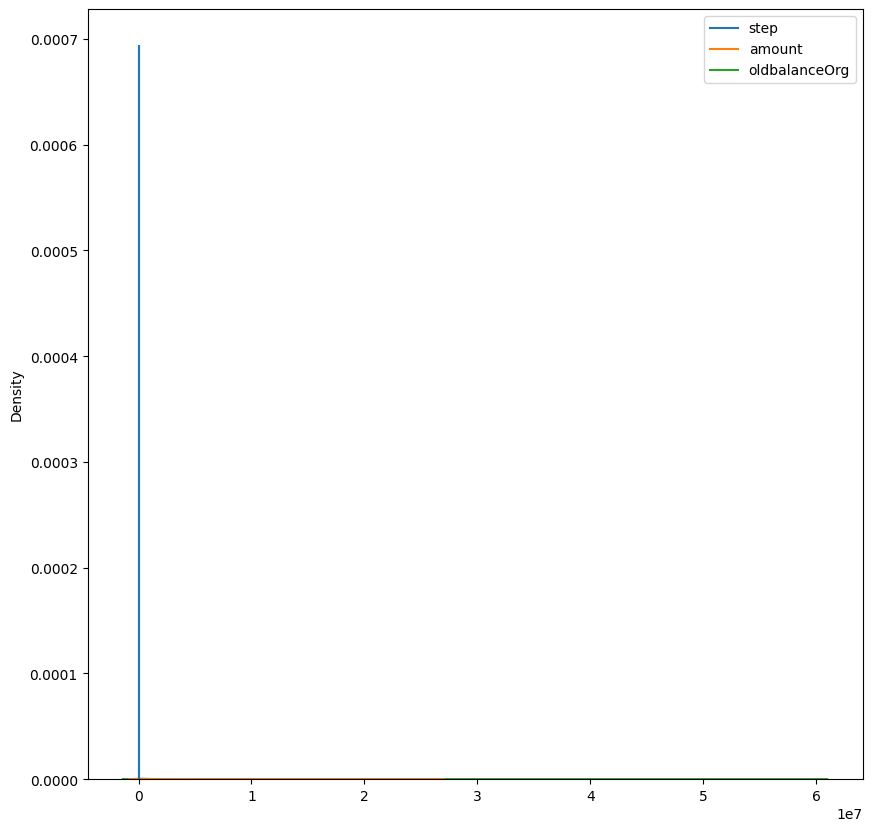

In [ ]:
plt.rcParams['figure.figsize']=[10,10]
sns.kdeplot(data=new_df.iloc[:,:3])

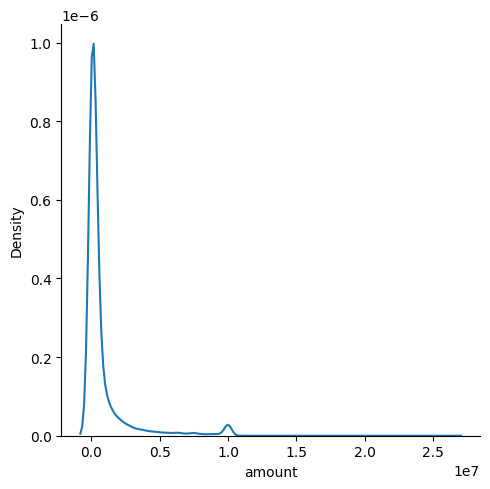

In [ ]:
 sns.displot(new_df, x="amount", kind="kde")

<Axes: xlabel='oldbalanceOrg', ylabel='Density'>

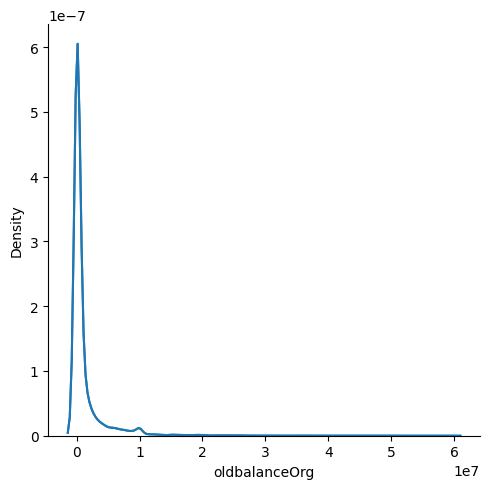

In [ ]:
 sns.displot(new_df, x="oldbalanceOrg", kind="kde")
sns.kdeplot(data=new_df.oldbalanceOrg)

In [ ]:
print('Distribución del dataset en términos de mínimos y máximos por variable:')
mins = [new_df[col].min() for col in new_df.columns]
print('Minimos por variable: ', mins)
maxs = [new_df[col].max() for col in new_df.columns]
print('Maximos por variable: ', maxs)

Distribución del dataset en términos de mínimos y máximos por variable:
Minimos por variable:  [1, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0]
Maximos por variable:  [743, 26234188.21, 59585040.37, 49585040.37, 236230516.82, 236726494.66, 1, 1, 1, 1, 1, 1, 1]


Para proceder a la normalización se debe tener en cuenta que existen distintas formas de proceder. Se puede normalizar con varios métodos.

- Minmax
- Z-score
- Por escalado decimal

In [ ]:
col_names = new_df.iloc[:,:6].columns

In [ ]:
col_names

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

### **StandarScaler**
Se utiliza la función StandarScaler(), para implementar la normalización z-score



In [ ]:
# Normalización
s_scaler = StandardScaler()
df_s = s_scaler.fit_transform(new_df.iloc[:,:6])
df_s = pd.DataFrame(df_s, columns=col_names)

<Axes: ylabel='Density'>

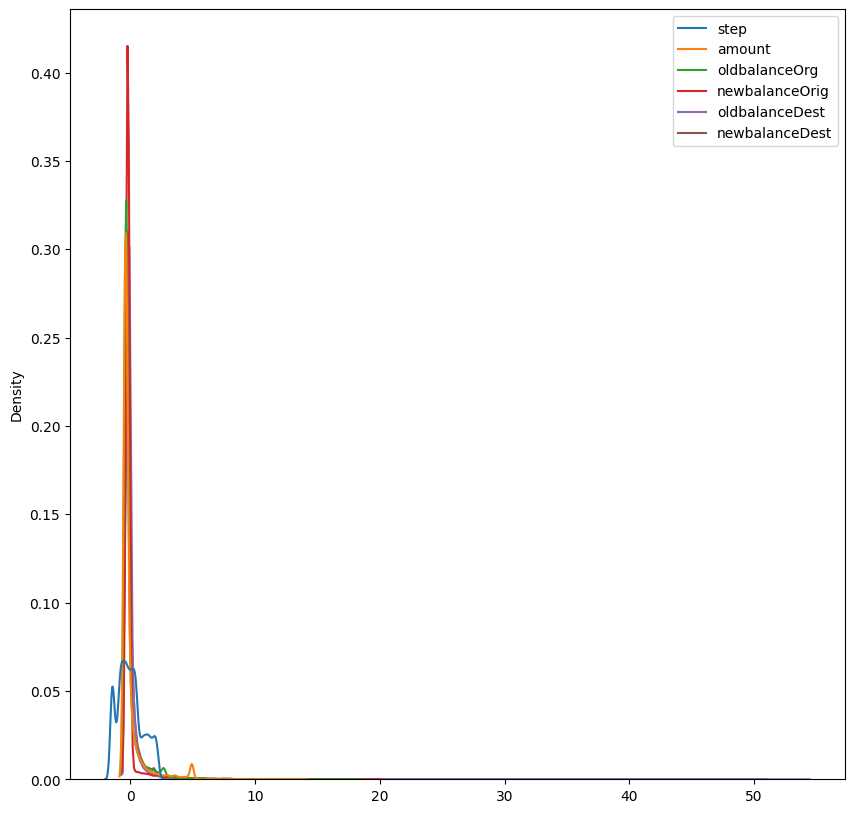

In [ ]:
plt.rcParams['figure.figsize']=[10,10]
sns.kdeplot(data=df_s[col_names])

Veamos cómo quedan los valores mínimo y máximo de cada atributo mediante este método.



In [ ]:
# Se concatena el dataset normalizado de las variables cuantitativas con los factores
df_s = pd.concat([df_s, new_df.iloc[:,6:]], axis = 1)

In [ ]:
print('Distribución del dataset en términos de mínimos y máximos por variable DESPUES DE NORMALIZAR:')

mins = [df_s[col].min() for col in df_s.columns]
print('Minimos por variable: ', mins)
maxs = [df_s[col].max() for col in df_s.columns]
print('Maximos por variable: ', maxs)

Distribución del dataset en términos de mínimos y máximos por variable DESPUES DE NORMALIZAR:
Minimos por variable:  [-1.5795370504415407, -0.44092995611194974, -0.3831931091046901, -0.2113487125176284, -0.1975172701979642, -0.27636453193385274, 0, 0, 0, 0, 0, 0, 0]
Maximos por variable:  [2.2535403112248518, 13.663054546174962, 17.950316179603153, 19.613574170565748, 54.03837264604276, 50.6132366324205, 1, 1, 1, 1, 1, 1, 1]


Se observa que ahora las variables están en un rango más parecido.



In [ ]:
df_s

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
0,-0.866647,-0.298029,-0.383193,-0.211349,-0.024942,-0.057636,0,1,0,0,0,0,0
1,1.457996,-0.434867,-0.383193,-0.211349,-0.146785,-0.226437,0,1,0,0,0,0,0
2,-0.117595,-0.432133,-0.372127,-0.203511,-0.197517,-0.276365,0,0,0,1,0,0,0
3,-1.393566,-0.383285,6.002110,8.128767,-0.012791,-0.153463,1,0,0,0,0,0,0
4,-0.102098,-0.438952,-0.383193,-0.211349,-0.197517,-0.276365,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16421,2.253540,-0.258311,-0.278678,-0.211349,-0.197517,-0.203342,0,1,0,0,0,0,1
16422,2.253540,2.952200,1.558742,-0.211349,-0.197517,-0.276365,0,0,0,0,1,0,1
16423,2.253540,2.952200,1.558742,-0.211349,-0.181793,1.095136,0,1,0,0,0,0,1
16424,2.253540,0.016047,-0.121659,-0.211349,-0.197517,-0.276365,0,0,0,0,1,0,1


## **Selección de características**
El Recursive Feature Elimination es un método de selección de variables envolvente, que se adapta a un modelo y elimina las características más débiles hasta que se alcanza el número especificado de variables.

Se va a realizar el RFE con el modelo de regresión logística, y especificando, como prueba, 3 características

### **Regresion Logistica**

In [ ]:


# Se escoge el modelo para evaluar el subset de atributos
LR = LogisticRegression()

# Se escoge el número de los atributos a seleccionar
rfe = RFE(estimator=LR, n_features_to_select=3)

X = new_df.drop(columns=["isFraud", "isFlaggedFraud"])
y = new_df.isFraud

rfe = rfe.fit(X, y)

print('Mejores características: ', X.columns[rfe.support_])


Mejores características:  Index(['step', 'oldbalanceOrg', 'newbalanceOrig'], dtype='object')


In [ ]:
selected_rfe_features = pd.DataFrame({'Variable':list(X.columns), 'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Variable,Ranking
0,step,1
2,oldbalanceOrg,1
3,newbalanceOrig,1
5,newbalanceDest,2
4,oldbalanceDest,3
9,PAYMENT,4
1,amount,5
7,CASH_OUT,6
10,TRANSFER,7
6,CASH_IN,8


Se aprecia que a algunas características se les da el puesto número 1 en el ranking, estas son las que más información de valor proporciona a la variable respuesta, isFraud.

Las variables oldbalanceOrg y newbalanceOrg parecen ser importantes. No obstante, en la matriz de correlación se vio que estas tienen una correlación del 100%, por lo que son redundantes.

Hay que valorar la posibilidad de eliminar una de ellas.

In [ ]:
old_dest = dataset[dataset['oldbalanceOrg'] == 0 ].count()['oldbalanceDest']
print('Veces que aparece la variable oldbalanceOrg = 0: ', old_dest)

Veces que aparece la variable oldbalanceOrg = 0:  2102449


In [ ]:
new_dest = dataset[dataset['newbalanceOrig'] == 0 ].count()['newbalanceDest']
print('Veces que aparece la variable newbalanceOrig = 0: ', new_dest)

Veces que aparece la variable newbalanceOrig = 0:  3609566


In [ ]:
both_dest =  dataset[dataset['newbalanceOrig'] == 0 & (dataset['oldbalanceOrg'] == 0)].count()['oldbalanceDest']
print('Veces que aparecen ambas variables, newbalanceOrig = oldbalanceOrg = 0: ', both_dest)

Veces que aparecen ambas variables, newbalanceOrig = oldbalanceOrg = 0:  3609566


### **Random Forest**

In [ ]:
# Se escoge el modelo para evaluar el subset de atributos
RF = RandomForestClassifier()
# Se escoge el número de los atributos a seleccionar
rfe = RFE(estimator=RF, n_features_to_select=3)
X = new_df.drop(columns=["isFraud", "isFlaggedFraud"])
y = new_df.isFraud
rfe = rfe.fit(X, y)
print('Mejores características: ',X.columns[rfe.support_])



Mejores características:  Index(['amount', 'oldbalanceOrg', 'newbalanceOrig'], dtype='object')


In [ ]:
selected_rfe_features = pd.DataFrame({'Variable':list(X.columns), 'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Variable,Ranking
1,amount,1
2,oldbalanceOrg,1
3,newbalanceOrig,1
10,TRANSFER,2
0,step,3
5,newbalanceDest,4
9,PAYMENT,5
4,oldbalanceDest,6
7,CASH_OUT,7
6,CASH_IN,8


Ahora se vuelve a realizar el RFE pero con cross validation (RFECV). Este, además selecciona automáticamente el número de caracteristicas óptimo, no tienen que ser seleccionadas manualmente. El modelo será el Random Forest para apreciar si existen cambios significativos en la selección de variables.

In [ ]:
X = new_df.drop(columns=["isFraud", "isFlaggedFraud"])
y = new_df.isFraud
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier()
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=3,scoring='accuracy')   #3-fold cross-validation
rfecv = rfecv.fit(X, y)

print('Número óptimo de características :', rfecv.n_features_)
print('Mejores características :', X.columns[rfecv.support_])




Número óptimo de características : 7
Mejores características : Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest',
       'PAYMENT', 'TRANSFER'],
      dtype='object')


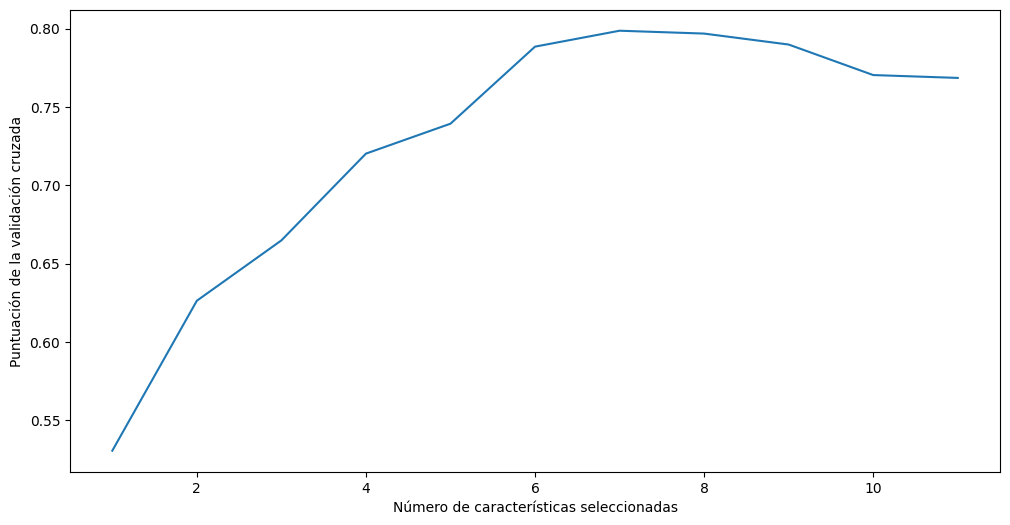

In [ ]:
# Graficar los resultados de la validación cruzada
plt.figure(figsize=(12, 6))
plt.xlabel('Número de características seleccionadas')
plt.ylabel('Puntuación de la validación cruzada')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

Se observa que el número óptimo de característica sería 3

###**Clasificadores**

Se evalúa este subconjunto óptimo de características aplicando distintos clasificadores

In [ ]:
# creo el dataframe sobre el que se va a ejecutar el modelo
df_RFE = new_df[['amount', 'oldbalanceOrg', 'newbalanceOrig','isFraud']]
df_RFE.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud'], dtype='object')

####**Regresion Logistica**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( df_RFE.drop(columns=["isFraud"]), df_RFE.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# predice la clase de test
predictions = LR.predict(test_X)

In [ ]:
# Evaluate predictions
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.902002556455049
[[ 951  223]
 [   7 1166]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1174
           1       0.84      0.99      0.91      1173

    accuracy                           0.90      2347
   macro avg       0.92      0.90      0.90      2347
weighted avg       0.92      0.90      0.90      2347



### **Arbol de decision**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( df_RFE.drop(columns=["isFraud"]), df_RFE.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
predictions = DT.predict(test_X)

In [ ]:
# Evaluate predictions
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT.predict(test_X)))

0.994034938219003
[[1168    6]
 [   8 1165]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1174
           1       0.99      0.99      0.99      1173

    accuracy                           0.99      2347
   macro avg       0.99      0.99      0.99      2347
weighted avg       0.99      0.99      0.99      2347



####**Random Forest**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( df_RFE.drop(columns='isFraud'), df_RFE.isFraud, test_size=1/7.0, random_state=0)

RF = RandomForestClassifier()

# se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# predice la clase de test
predictions = RF.predict(test_X)

# Evaluate predictions
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.9953131657435024
[[1169    5]
 [   6 1167]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1174
           1       1.00      0.99      1.00      1173

    accuracy                           1.00      2347
   macro avg       1.00      1.00      1.00      2347
weighted avg       1.00      1.00      1.00      2347



Se observa que si se ejecuta el clasificador random forest sobre el dataset incluyendo solo las 3 variables más importantes, se obtiene la misma precisión que con todas.

## **Reducción de dimensionalidad**



###**Principal Component Analysis (PCA)**

Principal Component Analysis es una técnica de Extracción de Características donde combinamos las entradas de una manera específica y podemos eliminar información de algunas de las variables manteniendo la parte más importante de todas las variables. Como valor añadido, luego de aplicar PCA conseguiremos que todas las nuevas variables sean independientes una de otra.

Este método es muy útil porque ayuda a crear los modelos predictivos mucho más rápido, al reducir la dimensionalidad del dataset

Para la reducción de dimensaionalidad es necesario tener los datos normalizados/estandarizados, como se ha hecho en el apartado anterior, asi que se procede a usar el dataset que cumple con estos requisitos, df_s

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(.95)

pca.fit(df_s.iloc[:,:6])
X_pca = pca.transform(df_s.iloc[:,:6])

print( 'El numero de componentes escogida ha sido: ',pca.n_components_)

El numero de componentes escogida ha sido:  4


Se comprueba que con 4 componentes se explica el 99% de los datos



In [ ]:
np.cumsum(pca.explained_variance_ratio_)


array([0.36674003, 0.6813162 , 0.86009895, 0.994333  ])

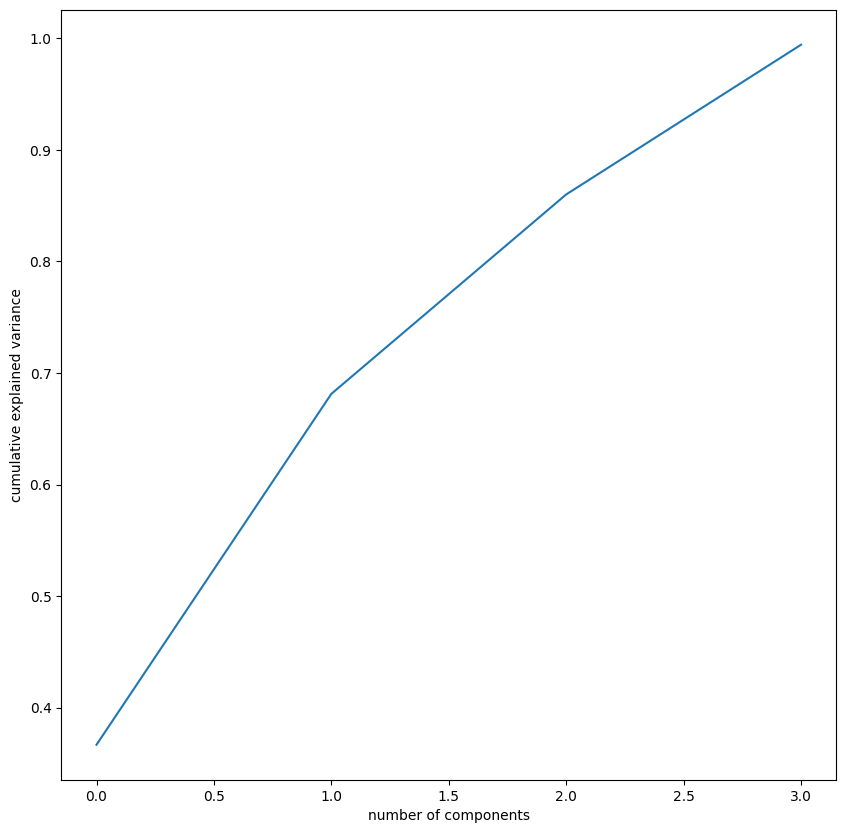

In [ ]:
# graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

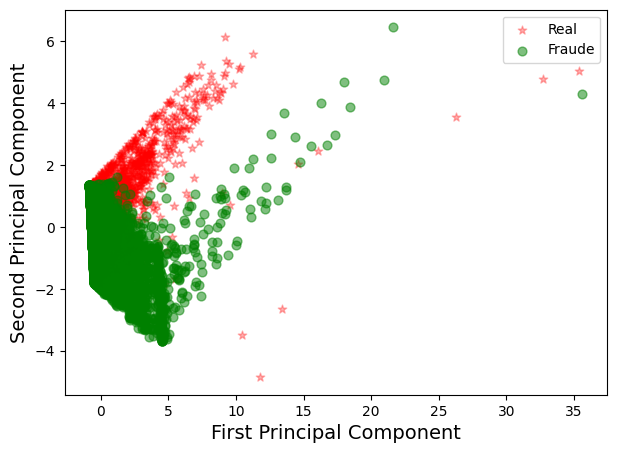

In [ ]:
#graficamos en 2 Dimensiones, tomando 2 de los componentes principales
Xax=X_pca[:,0]
Yax=X_pca[:,2]
labels=df_s['isFraud'].values
cdict={0:'red',1:'green'}
labl={0:'Real',1:'Fraude'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],label=labl[l],s=40,marker=marker[l],alpha=alpha[l])

plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

Creo un dataframe resultante del PCA, que contenga los 4 componentes y la varaible objetivo



In [ ]:
df_PCA = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
finalDf = pd.concat([df_PCA, df_s['isFraud']], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,principal component 4,isFraud
0,-0.565001,0.221357,0.719329,0.385139,0
1,-0.509905,-0.003697,-1.154759,-0.992789,0
2,-0.680154,-0.025643,0.141574,-0.110991,0
3,6.900763,-4.643097,4.890077,-3.323704,0
4,-0.691843,-0.018731,0.127639,-0.120487,0
...,...,...,...,...,...
16421,-0.302998,-0.109159,-1.877435,-1.310750,1
16422,2.174759,-1.291367,-3.005926,0.828215,1
16423,2.693989,-0.460140,-3.008441,0.884113,1
16424,-0.116303,-0.250178,-1.973672,-1.130789,1


### **Modelos predictivos con PCA**
Una vez se tienen los datos transformados, se procede a realizar la predicción de clases sobre el dataset de PCA



####**Árbol de Decisión**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns='isFraud'), finalDf.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
predictions = DT.predict(test_X)

In [ ]:
# Evaluate predictions
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT.predict(test_X)))

0.8559863655730721
[[ 980  194]
 [ 144 1029]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1174
           1       0.84      0.88      0.86      1173

    accuracy                           0.86      2347
   macro avg       0.86      0.86      0.86      2347
weighted avg       0.86      0.86      0.86      2347



Las observaciones se clasifican correctamente con un precisión del 85%, y ambas clases se clasifican relativamente con la misma precisión

####**Random Forest**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns='isFraud'), finalDf.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
RF = RandomForestClassifier()

# se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# predice la clase de test
predictions = RF.predict(test_X)

In [ ]:
# Evaluate predictions
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.8990200255645505
[[1077   97]
 [ 140 1033]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1174
           1       0.91      0.88      0.90      1173

    accuracy                           0.90      2347
   macro avg       0.90      0.90      0.90      2347
weighted avg       0.90      0.90      0.90      2347



El modelo clasifica correctamente el 90% de las observaciones. Se observa que clasifica mejor aquellas observaciones fraudulentas, pero no es una diferencia significativa.

####**Regresión Logística**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns='isFraud'), finalDf.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# predice la clase de test
predictions = LR.predict(test_X)

In [ ]:
# Evaluate predictions
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.8061354921175969
[[1036  138]
 [ 317  856]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1174
           1       0.86      0.73      0.79      1173

    accuracy                           0.81      2347
   macro avg       0.81      0.81      0.80      2347
weighted avg       0.81      0.81      0.80      2347



Sin embargo, con regresión logística los resultados obtenidos no son tan buenos, comparado a los anteriores

###**Definiendo manualmente el número de componentes**

Como se comentó antes, se pueden escoger directamente el número de componentes que se desean.

Se va a hacer de esta manera para ver el impacto que puede tener sobre la clasificación

In [ ]:
pca = PCA(n_components=3)

# utilizo el dataset sin normalizar
pca.fit(df_s.iloc[:,:6])
X_pca = pca.transform(df_s.iloc[:,:6])
print(pca.components_)

[[ 0.09332443  0.44269099  0.58989132  0.45781081  0.31163839  0.37501233]
 [-0.02959284 -0.15749009 -0.34442613 -0.3170789   0.62970528  0.59885224]
 [-0.82416216 -0.39162865  0.07000007  0.39023529  0.10095142 -0.0029913 ]]


In [ ]:
print(pca.explained_variance_)
print(pca.components_)
print(pca.explained_variance_ratio_)

[2.20057415 1.88757195 1.07276177]
[[ 0.09332443  0.44269099  0.58989132  0.45781081  0.31163839  0.37501233]
 [-0.02959284 -0.15749009 -0.34442613 -0.3170789   0.62970528  0.59885224]
 [-0.82416216 -0.39162865  0.07000007  0.39023529  0.10095142 -0.0029913 ]]
[0.36674003 0.31457617 0.17878274]


In [ ]:
np.cumsum(pca.explained_variance_ratio_)


array([0.36674003, 0.6813162 , 0.86009895])

In [ ]:
df_PCA = pd.DataFrame(data = X_pca[:,0:3], columns = ['principal component 1', 'principal component 2', 'principal component 3'])
df_PCA

,principal component 1,principal component 2,principal component 3
0,-0.565001,0.221357,0.719329
1,-0.509905,-0.003697,-1.154759
2,-0.680154,-0.025643,0.141574
3,6.900763,-4.643097,4.890077
4,-0.691843,-0.018731,0.127639
...,...,...,...
16421,-0.302998,-0.109159,-1.877435
16422,2.174759,-1.291367,-3.005926
16423,2.693989,-0.460140,-3.008441
16424,-0.116303,-0.250178,-1.973672


In [ ]:
finalDf = pd.concat([df_PCA, df_s['isFraud']], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,isFraud
0,-0.565001,0.221357,0.719329,0
1,-0.509905,-0.003697,-1.154759,0
2,-0.680154,-0.025643,0.141574,0
3,6.900763,-4.643097,4.890077,0
4,-0.691843,-0.018731,0.127639,0
...,...,...,...,...
16421,-0.302998,-0.109159,-1.877435,1
16422,2.174759,-1.291367,-3.005926,1
16423,2.693989,-0.460140,-3.008441,1
16424,-0.116303,-0.250178,-1.973672,1


Ahora, se pasa a comprobar la prediccion de las clases con este dataset



####**Árbol de Decisión**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns='isFraud'), finalDf.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
predictions = DT.predict(test_X)

In [ ]:
# Evaluate predictions
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT.predict(test_X)))

0.8035790370685982
[[909 265]
 [196 977]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1174
           1       0.79      0.83      0.81      1173

    accuracy                           0.80      2347
   macro avg       0.80      0.80      0.80      2347
weighted avg       0.80      0.80      0.80      2347



Se obtiene peor precisión que aplicando el mismo algoritmo bajo el dataset con 4 componentes



####**Random Forest**

In [ ]:
# Se divide el dataset
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns=["isFraud"]), new_df.isFraud, test_size=1/7.0, random_state=0)
RF = RandomForestClassifier()
RF.fit(train_X, train_y)

# predice la clase de test
predictions = RF.predict(test_X)

In [ ]:
# Evaluate predictions
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.8495952279505752
[[1000  174]
 [ 179  994]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1174
           1       0.85      0.85      0.85      1173

    accuracy                           0.85      2347
   macro avg       0.85      0.85      0.85      2347
weighted avg       0.85      0.85      0.85      2347



La predicción del modelo es del 86%, un poco menos que el caso anterior, dado que se han escogidos menos componentes

####**Regresión Logística**

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns='isFraud'), finalDf.isFraud, test_size=1/7.0, random_state=0)

# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# predice la clase de test
predictions = LR.predict(test_X)

In [ ]:
# Evaluate predictions
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.6927993182786536
[[882 292]
 [429 744]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1174
           1       0.72      0.63      0.67      1173

    accuracy                           0.69      2347
   macro avg       0.70      0.69      0.69      2347
weighted avg       0.70      0.69      0.69      2347



Con Regresión Logística los resultados obtenidos no son muy buenos, con lo cual, se concluye que es mejor idea quedarse con el dataset compuesto con 4 componentes

# **Guardar datasets preprocesados**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.to_csv('/content/drive/MyDrive/data_balanceada_normalizada.csv', index=False)
new_df.to_csv('/content/drive/MyDrive/data_balanceada.csv', index=False)


#**Conclusiones**

##**Resultado de los clasificadores**
Como resultado del estudio, se quiere concluir con una comparativa de los algoritmos aplicados durante el aprendizaje supervisado, en distintas etapas, para definir cuales han sido los mejores.



###**Dataset original**

En el datadet de más de 6 millones de observaciones, se han aplicado 3 algoritmos:

- Árbol de decisión

- Regresión Logística

- Random Forest



Los resultados han sido:

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( dataset.drop(columns=["isFraud"]), dataset.isFraud, test_size=1/7.0, random_state=0)

names = ["Decision_Tree", "Random_Forest", "Logistic_Regression"]

classifiers = [
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression()]

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    scores.append(score)
    #print("{} {}({})"(name, score.mean(), score.std()))

Si se mira a la siguiente tabla y gráfica, puede parecer que los tres clasificadores están muy reñidos, sin embargo, a continuación se procede a demostrar que hay enormes diferencias entre los modelos, ya que la precisión no es la única métrica a tener en cuenta a la hora de elegir el modelo

In [ ]:
df_comp = pd.DataFrame()
df_comp['name'] = names
df_comp['score'] = scores
df_comp

,name,score
0,Decision_Tree,0.999716
1,Random_Forest,0.999716
2,Logistic_Regression,0.998227


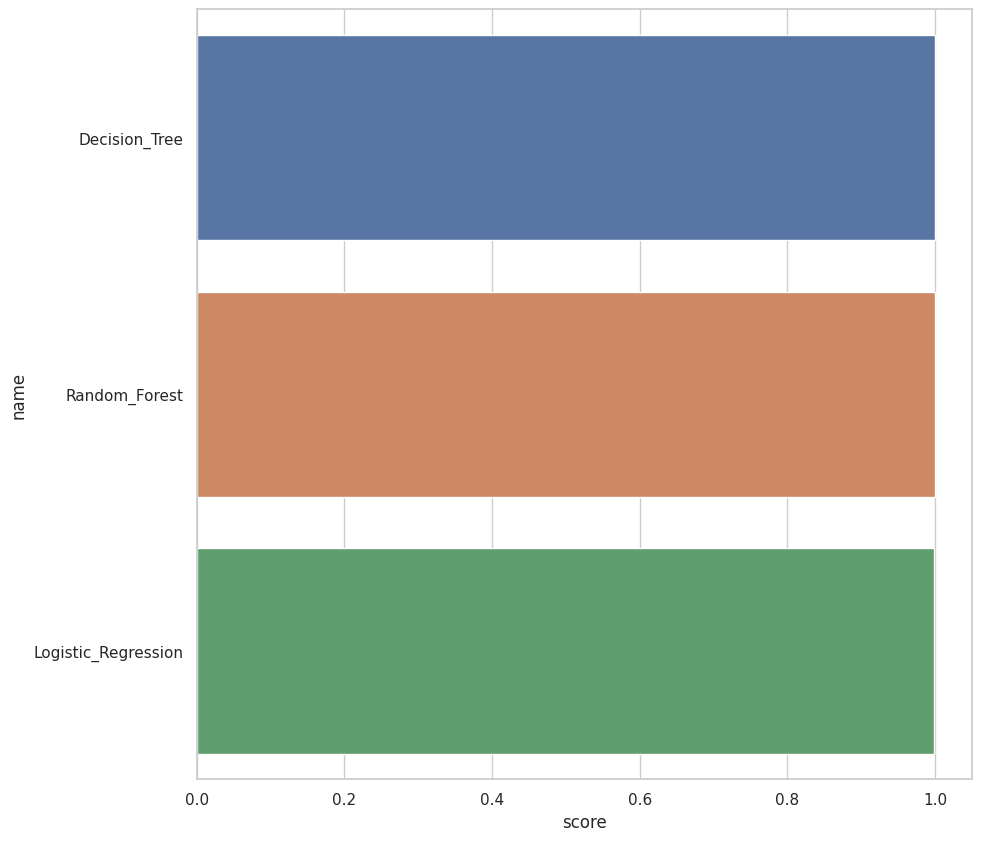

In [ ]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df_comp)

####**Regresión Logística**

Se aprecia que la precisión es muy alta, sin embargo, si se mira la proporción de precisión en cada clase, está muy descompensado, esto se debe a que la clase 1 (Fraude), sólo representa el 0.13% de las observaciones, con lo que se concluye que, aunque el modelo tengan un muy buen comportamiento, a priori, mirando el porcentaje de acierto en la clasificación, realmente, es un MAL modelo

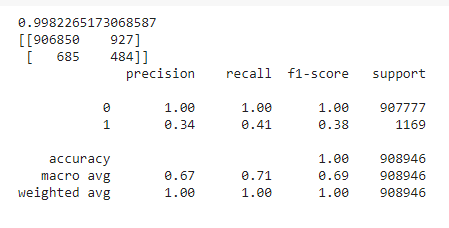

####**Decision Tree**

En el siguiente modelo, se aprecia que mejora exponencialmente la capacidad predictiva en la clase minoritaria, lo que lleva a pensar que los clasificadores basados en árboles realizan mejor trabajo sobre el conjunto de datos

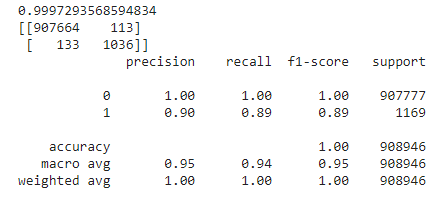

###**Dataset balanceado y normalizado**

Después del balanceo, se han ejecutado los mismos algoritmos sobre el dataset balanceado y se obtiene:

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( df_s.drop(columns=["isFraud"]), df_s.isFraud, test_size=1/7.0, random_state=0)

names = ["Decision_Tree", "Random_Forest", "Logistic_Regression"]

classifiers = [
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression()]

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    scores.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
df_comp = pd.DataFrame()
df_comp['name'] = names
df_comp['score'] = scores
df_comp

,name,score
0,Decision_Tree,0.987218
1,Random_Forest,0.992757
2,Logistic_Regression,0.925863


####**Regresión Logística**

Con respecto al dataset sin balanceo, la precesión ha disminuido en el algoritmo de Regresión Logística, lo que parecería que lo convierte en un peor modelo, pero no es así. Si se comprueba la precisión en la predicción de cada clase, se aprecia que en el caso de 0 (No fraude), ha disminuido un 8%, antes era del 100% aciertos, pero la anteriormente minoritaria, 1 (Fraude), ha aumentado del 34% al 93%, lo que supone un importantísimo aumento en la precisión. Este modelo es infinitamente superior al anterior de regresión logistica, aplicado sobre el dataset sin balancear. Esta mejora ha sido posible gracias al undersampling aplicado al dataset, para que el modelo aprende por igual como clasificar ambas clases.

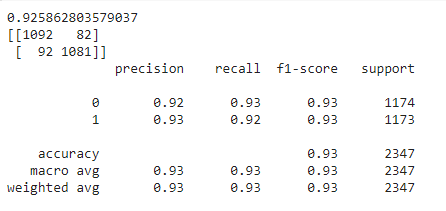

####**Árbol de Decisión**

De nuevo, la precisión general ha disminuido un 1%, pero la precisión en la clase 1, ha aumentado un 9%, convirtiendo el modelo en un modelo casi perfecto, clasificando correctamente todas las observaciones un 99% de las veces, independientemente de su clase.

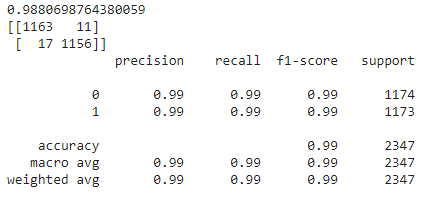

####**Random Forest**

Por último, el Random Forest vuelve a tener los mejores resultados, asemejándose a los resultados del Árbol de Decisión. No se han notado diferencias significativas con el clasificador aplicado al dataset sin balancear y balanceado. Sólo apreciar que disminuye ligeramente la precesión en la case 0 y aumenta en la clase 1, igualando a ambas en precisión a un 0.99

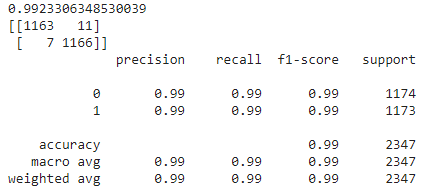

###**Dataset con RFE**

Se realiza la comparación con el dataset resultante del RFE y que consta de 3 atributos y la variable objetivo:

In [ ]:
df_RFE.head()


,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,265803.35,0.00,0.00,0
1,11278.28,0.00,0.00,0
2,16363.06,35966.16,19603.10,0
3,107223.31,20752629.71,20859853.02,0
4,3678.25,0.00,0.00,0


In [ ]:
train_X, test_X, train_y, test_y = train_test_split( df_RFE.drop(columns=["isFraud"]), df_RFE.isFraud, test_size=1/7.0, random_state=0)

names = ["Decision_Tree", "Random_Forest", "Logistic_Regression"]

classifiers = [
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression()]

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    scores.append(score)

In [ ]:
df_compPCA = pd.DataFrame()
df_compPCA['name'] = names
df_compPCA['score'] = scores
df_compPCA

,name,score
0,Decision_Tree,0.994035
1,Random_Forest,0.995313
2,Logistic_Regression,0.902003


####**Regresión Logística**

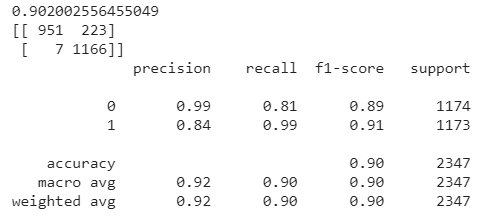

####**Árbol de Decisión**

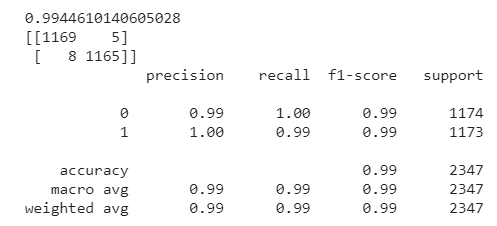

####**Random Forest**

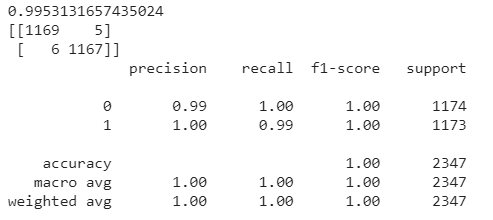

Se aprecia que el algortimo de Regresión logística es bastante inferior en cuanto en resultados, en este dataset.

Entre el árbol de decisión y el Random Forest, los resultados son prácticamente idénticos.

Esto demuestra que no son necesarias tantas variables para realizar la predicción, ya que solo con 3 variables predictoras, se está teniendo una mejor predicción que con todas las variables.

### **Dataset con PCA**

Por último, sobre el dataset formado por 4 componentes principales, se ejecutan los mismo algoritmos y se obtiene:

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( finalDf.drop(columns=["isFraud"]), finalDf.isFraud, test_size=1/7.0, random_state=0)

names = ["Decision_Tree", "Random_Forest", "Logistic_Regression"]

classifiers = [
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression()]

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    scores.append(score)


In [ ]:
df_compPCA = pd.DataFrame()
df_compPCA['name'] = names
df_compPCA['score'] = scores
df_compPCA

,name,score
0,Decision_Tree,0.801875
1,Random_Forest,0.854282
2,Logistic_Regression,0.692799


####**Regresión Logística**

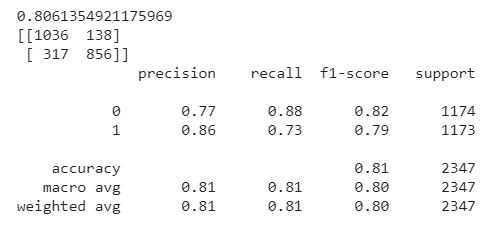

####**Árbol de Decisión**

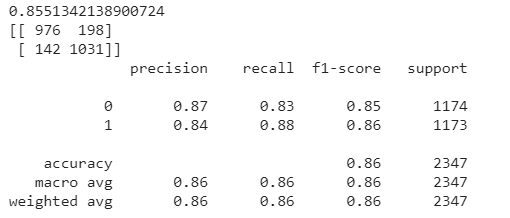


####**Random Forest**


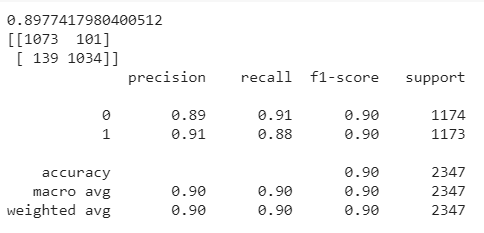

La predicción sobre este dataset no parece ser tan buena como en los 2 anteriores, por ello, una consideración para aumentar la capacidad predictiva es aumentar el número de componentes principales

Como conclusión final, se observa que el Random Forest es el clasificador que mejor actúa sobre los datos, seguido del Árbol de decisión y por último, el de Regresión Logística.